In [68]:
import numpy as np
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # copied over from ipynb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords # tried to use this vocab but ended up with lower accuracy than the built in stopwords
nltk.download('stopwords')

SEED = 12345

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lavanya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
from matplotlib import pyplot as plt

import seaborn as sns
#This sets the default style for all figures. 
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [81]:
# load the csv files
if __name__ == '__main__':
    data_dir = 'data_reviews'
    x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
    y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

    N, n_cols = x_train_df.shape
    print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
    print("Shape of y_train_df: %s" % str(y_train_df.shape))

    # Print out the first five rows and last five rows
    tr_text_list = x_train_df['text'].values.tolist()
    rows = np.arange(0, 5)
    for row_id in rows:
        text = tr_text_list[row_id]
        print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

    print("...")
    rows = np.arange(N - 5, N)
    for row_id in rows:
        text = tr_text_list[row_id]
        print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

Shape of x_train_df: (2400, 2)
Shape of y_train_df: (2400, 1)
row     0 | y = 0 | Oh and I forgot to also mention the weird color effect it has on your phone.
row     1 | y = 0 | THAT one didn't work either.
row     2 | y = 0 | Waste of 13 bucks.
row     3 | y = 0 | Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.
row     4 | y = 0 | None of the three sizes they sent with the headset would stay in my ears.
...
row  2395 | y = 1 | The sweet potato fries were very good and seasoned well.
row  2396 | y = 1 | I could eat their bruschetta all day it is devine.
row  2397 | y = 1 | Ambience is perfect.
row  2398 | y = 1 | We ordered the duck rare and it was pink and tender on the inside with a nice char on the outside.
row  2399 | y = 1 | Service was good and the company was better!


# Problem 1:

In [82]:
# Splitting up training data into training set and validation set
x_train, x_va, y_train, y_va = train_test_split(x_train_df['text'], y_train_df, test_size=0.2, random_state=SEED)
y_train = y_train.values.ravel()
y_va = y_va.values.ravel()

In [116]:
# define logistic regression pipeline function
def make_log_regr_pipeline():
    pipeline = Pipeline(
        steps=[
         ('vectorizer', CountVectorizer(
             lowercase=True, # make the text uniformly lowercase
             stop_words='english', # remove filler words ('a', 'the', etc.) present in the stopwords nltk library
             analyzer='word', # breakdown text into words for feature analysis
             max_df=0.50, # ignore words with a frequency strictly higher than 50%
             token_pattern=r'\b\w+\b' # removes punctuation and numbers
             )
            ),
         ('log_regr', LogisticRegression(penalty='l2', max_iter=10000)),
        ])
    return pipeline

In [120]:
# initialize pipeline
pipe = make_log_regr_pipeline()

# fit pipeline to training data
pipe.fit(x_train, y_train)

# make predictions on validation data
predictions_tr = pipe.predict(x_train)
predictions_va = pipe.predict(x_va)

# calculate and print accuracy
print(f"Training Accuracy: {accuracy_score(y_train, predictions_tr)}")
print(f"Validation Accuracy: {accuracy_score(y_va, predictions_va)}")

Training Accuracy: 0.9609375
Validation Accuracy: 0.80625


In [ ]:
# make hyperparameter C grid (regularization strength), 20 logspaced values from 10e-6 to 10e6
C_grid = np.logspace(-6, 6, 20)
param_grid = {'log_regr__C': C_grid}

In [122]:
# make hyperparameter C grid (regularization strength), 20 logspaced values from 10e-6 to 10e6
C_grid = np.logspace(-6, 6, 20)
param_grid = {'log_regr__C': C_grid}

# perform grid search and fit the model
grid_search = sklearn.model_selection.GridSearchCV(
    pipe, # estimator
    param_grid=param_grid, # hyperparameter C
    cv=5, # 5-fold cross validation
    scoring='roc_auc' # calculates AUROC to compare the hyperparameter(s)
)

grid_search.fit(x_train, y_train)
grid_predictions_va = grid_search.predict(x_va)
grid_predictions_tr = grid_search.predict(x_train)

# calculate and print accuracy for training and validation datasets
print("Training Accuracy:", accuracy_score(y_train, grid_predictions_tr))
print("Validation Accuracy:", accuracy_score(y_va, grid_predictions_va))

# best parameter found in the grid search
print("Best C:", grid_search.best_params_)

Training Accuracy: 0.9734375
Validation Accuracy: 0.8166666666666667
Best C: {'log_regr__C': 2.06913808111479}


Best C: 2.06913808111479
Best AUROC score: 0.8751959512436439


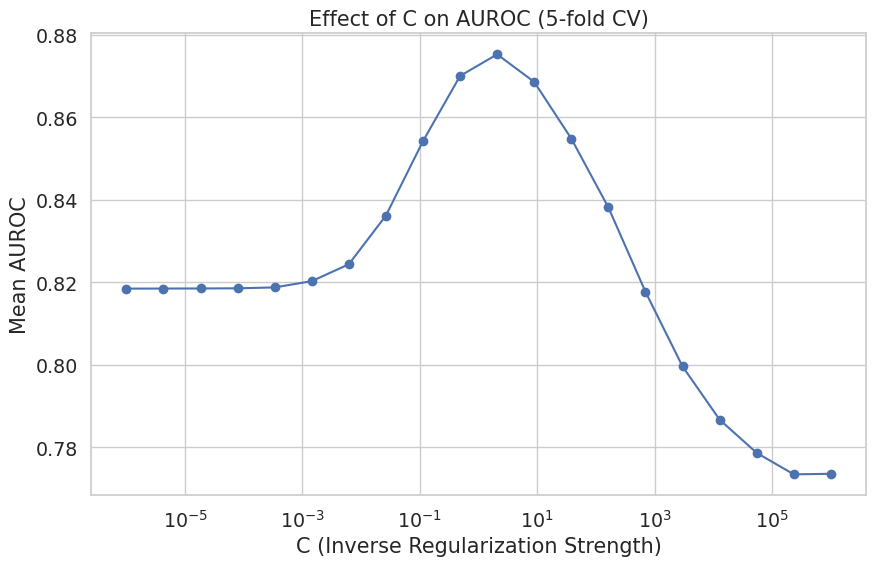

In [123]:
 # print best parameter and best score
print(f'Best C: {grid_search.best_params_["log_regr__C"]}')
print(f'Best AUROC score: {grid_search.best_score_}')

# plot the performance of different regularization strengths
scores = grid_search.cv_results_['mean_test_score']

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(C_grid, scores, marker='o')
ax.set_xscale('log')
ax.set_xlabel('C (Inverse Regularization Strength)')
ax.set_ylabel('Mean AUROC')
ax.set_title('Effect of C on AUROC (5-fold CV)')
plt.show()

The peak of the graph indicates the best C value - this will prevent over- and under-fitting to the training data. 